# ML class final project part1
##  Almog Shor
## Yehudit Brickner

imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import warnings

#filter out warnings
# filter out User warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
#filter out Future warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
#filter out Deprecation warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
#filter out Runtime warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)


In [2]:
# create known and like-global variables

fourier_len = 0
sobel_len = 0

project_scope = [0, 9, 10, 11]
is_ball = [0,10]
not_ball = [9, 11]

create the data set with all of the features

In [3]:
def fourier_transform(image):
    global fourier_len
    # Perform a 2D Fast Fourier Transform on the image.
    # The fft2 function computes the 2D discrete Fourier Transform.
    # This converts the image from the spatial domain to the frequency domain.
    f = np.fft.fft2(image)
    # Shift the zero-frequency component to the center of the spectrum.
    # The fftshift function is used to move the low frequencies to the center of the FFT.
    # This is a common step in processing images, as it makes the low frequencies more accessible.
    fshift = np.fft.fftshift(f)
    # Compute the magnitude spectrum of the shifted FFT.
    # This step converts the complex values from the FFT into a magnitude,
    # which represents the amount of each frequency present in the original image.
    # The logarithmic scale (log) is used to reduce the dynamic range of the values,
    # making the spectrum easier to analyze visually or computationally.
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    fourier_len = len(magnitude_spectrum.flatten()[::2])
    return magnitude_spectrum.flatten()[::2]

In [4]:
def sobel_edges(image):
    global sobel_len
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)  # Horizontal edge detection
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)  # Vertical edge detection
    sobelx = np.uint8(np.absolute(sobelx))  # Absolute value and conversion to uint8
    sobely = np.uint8(np.absolute(sobely))  # Absolute value and conversion to uint8
    sobel_combined = cv2.bitwise_or(sobelx, sobely)  # Combine horizontal and vertical edges
    sobel_len = len(sobel_combined.flatten()[::2])
    return sobel_combined.flatten()[::2]  # Return every 5th element of the flattened array


In [5]:
def create_df1(folder):
    folder_dir = os.listdir(folder)
    sphere_balls = ['american_football', 'rugby_ball']  # change to the balls u want...
    non_sphere_balls = ['hockey_puck', 'shuttlecock']  # change to the balls u want...
    # the list to hold all the data - will be converted to a df
    final_df_list = []

    count = 0
    c = 0
    for i in folder_dir:
        print(i)
        j = os.listdir(folder + "/" + i)
        if i in sphere_balls or i in non_sphere_balls:
            for k in range(len(j)):
                try:
                    img = cv2.imread(folder + "/" + i + "/" + j[k], cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)

                    histogram_r, bin_edges = np.histogram(img[:, :, 0], bins=256, range=(0, 256))
                    histogram_g, bin_edges = np.histogram(img[:, :, 1], bins=256, range=(0, 256))
                    histogram_b, bin_edges = np.histogram(img[:, :, 2], bins=256, range=(0, 256))

                    dst = cv2.Canny(img, 50, 200, None, 3)
                    dst1 = cv2.Canny(img, 50, 200, None, 3)
                    lines = cv2.HoughLines(dst1, 1, np.pi / 180, 50, None, 0, 0)

                    gray = cv2.imread(folder + "/" + i + "/" + j[k], cv2.IMREAD_GRAYSCALE)
                    gray = cv2.resize(gray, (200, 200), interpolation=cv2.INTER_AREA)
                    gray = cv2.medianBlur(gray, 5)
                    rows = gray.shape[0]
                    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                                               param1=100, param2=30,
                                               minRadius=10, maxRadius=100)

                    my_list = []
                    my_list.append(folder + "/" + i + "/" + j[k])
                    my_list.append(i)
                    my_list.append(c)
                    if i in sphere_balls:
                        my_list.append(0)  # ball is sphere
                    elif i in non_sphere_balls:
                        my_list.append(1)  # ball is non sphere
                    else:
                        my_list.append(-1)  # not in either list - shouldn't get here
                    if lines is None:
                        my_list.append(0)
                        my_list.append(0)
                    else:
                        my_list.append(1)
                        my_list.append(len(lines))
                    if circles is None:
                        my_list.append(0)
                        my_list.append(0)
                    else:
                        my_list.append(1)
                        my_list.append(circles.shape[1])

                    my_list.extend(histogram_r)
                    my_list.extend(histogram_g)
                    my_list.extend(histogram_b)

                    #Fourier Transform Feature
                    fourier_feature = fourier_transform(img)
                    
                    if fourier_feature.size >0:
                        # fourier_len = len(fourier_feature)
                        print(fourier_len, len(fourier_feature), fourier_feature.size)
                        my_list.extend(fourier_feature)
                    else:
                        print(f"Fourier feature is empty for img: {i}/{j[k]}")

                    # Sobel Edges Feature
                    sobel_feature = sobel_edges(img)
                    
                    if sobel_feature.size > 0:
                        # sobel_len = len(sobel_feature)
                        print(sobel_len, len(sobel_feature), sobel_feature.size)
                        my_list.extend(sobel_feature)
                    else:
                        print(f"Sobel feature is empty for img: {i}/{j[k]}")
                    
                    # Append the list to the final list    
                    final_df_list.append(my_list)
                    count += 1

                except Exception as er:
                    print(f"${er} There was an error with count ", count)

        c += 1

    print("creating df")
    cols = ['path', 'class_name', 'class_number', 'type', 'lines?', '#lines', 'circles?', '#circles']
    for h in range(256):
        cols.append("r" + str(h))
    for h in range(256):
        cols.append("g" + str(h))
    for h in range(256):
        cols.append("b" + str(h))
    for idx in range(fourier_len):
        cols.append("f" + str(idx))
    for idx in range(sobel_len):
        cols.append("s" + str(idx))

    df = pd.DataFrame(final_df_list, columns=cols)

    print("created df")

    return df

In [6]:
folder = "C:/Users/shora/Documents/Semster A/Machine Learning/archive/train"
start_time = time.time()
# create df with all features
full_ball_df = create_df1(folder)
end_time = time.time()
print("time taken: ", end_time - start_time)

american_football
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 6000

In [7]:
full_ball_df.head(50)

,path,class_name,class_number,type,lines?,#lines,circles?,#circles,r0,r1,...,s59990,s59991,s59992,s59993,s59994,s59995,s59996,s59997,s59998,s59999
0,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,36,1,5,2,3,...,160,150,150,170,156,154,98,46,84,0
1,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,207,1,6,2,4,...,0,0,0,0,0,0,0,0,0,0
2,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,55,1,5,0,0,...,148,104,108,22,32,6,90,12,196,0
3,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,196,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,291,1,12,4529,4546,...,6,196,196,78,120,120,200,82,82,0
5,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,4,1,2,65,49,...,0,0,0,0,0,0,0,0,0,0
6,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,232,1,9,0,2,...,38,42,42,42,10,10,36,42,42,0
7,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,1379,1,15,290,261,...,0,0,0,0,0,0,0,0,0,0
8,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,1,2,0,0,27,39,...,0,0,0,0,0,0,0,0,0,0
9,C:/Users/shora/Documents/Semster A/Machine Lea...,american_football,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
full_ball_df.to_csv('small_hist.csv', index=False)

In [9]:
folder = "C:/Users/shora/Documents/Semster A/Machine Learning/archive/test"
start_time = time.time()

full_test_df = create_df1(folder)
end_time = time.time()
print("time taken: ", end_time - start_time)

american_football
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 60000 60000
60000 6000

In [10]:
full_test_df.to_csv('final_test_data_small_hist.csv', index=False)

import the data with some/all features

In [11]:
small_hist = pd.read_csv('small_hist.csv')
del small_hist['path']
del small_hist['class_name']
small_hist_4balls = small_hist.loc[small_hist['class_number'].isin(project_scope)]
del small_hist_4balls['class_number']
small_hist_4balls.shape

(1688, 120773)

In [12]:
#cleaning the data
small_hist_4balls = small_hist_4balls.replace([np.inf, -np.inf], np.nan)

small_hist_4balls = small_hist_4balls.fillna(small_hist_4balls.mean())

In [13]:

X_Cir_Lns = small_hist_4balls.iloc[:, 1:5]  # Is there circles and lines,  and how many?
X_Histogram = small_hist_4balls.iloc[:, 5: 5 + (256 * 3)]  # histogram
#extra
X_Fourier = small_hist_4balls.iloc[:, 5 + (256 * 3):5 + (256 * 3) + fourier_len]  # Fourier Transform
X_Sobel = small_hist_4balls.iloc[:, 5 + (256 * 3) + fourier_len:5 + (256 * 3) + fourier_len + sobel_len]  # Sobel Edges

X_all = small_hist_4balls.drop(['type'], axis=1)  # all features except type

# creating good mixes of features
# Hist & sobel
X_Hist_Sobel = pd.concat([X_Histogram, X_Sobel], axis=1)
# Cir_Lns and Hist
X_cir_Lns_Hist = pd.concat([X_Cir_Lns, X_Histogram], axis=1)
#X_Fourier & X_Histogram
X_Fourier_Hist = pd.concat([X_Fourier, X_Histogram], axis=1)

y = small_hist_4balls['type']  # class number


In [14]:
print(X_Cir_Lns.shape)
print(X_Histogram.shape)
print(X_Fourier.shape)
print(X_Sobel.shape)
print(X_all.shape)
print(y.shape)

(1688, 4)
(1688, 768)
(1688, 60000)
(1688, 60000)
(1688, 120772)
(1688,)


train test split

In [15]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_Cir_Lns, y, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_Histogram, y, test_size=0.2, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_cir_Lns_Hist, y, test_size=0.2, random_state=42)

X_train_Fourier, X_test_Fourier, y_train_Fourier, y_test_Fourier = train_test_split(X_Fourier, y, test_size=0.2,
                                                                                    random_state=42)
X_train_Sobel, X_test_Sobel, y_train_Sobel, y_test_Sobel = train_test_split(X_Sobel, y, test_size=0.2, random_state=42)
X_train_Hist_Sobel, X_test_Hist_Sobel, y_train_Hist_Sobel, y_test_Hist_Sobel = train_test_split(X_Hist_Sobel, y,
                                                                                                test_size=0.2,
                                                                                                random_state=42)
X_train_Fourier_Hist, X_test_Fourier_Hist, y_train_Fourier_Hist, y_test_Fourier_Hist = train_test_split(X_Fourier_Hist,
                                                                                                        y,
                                                                                                        test_size=0.2,
                                                                                                        random_state=42)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42)

print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)
print(X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape)

(1350, 4) (338, 4) (1350,) (338,)
(1350, 768) (338, 768) (1350,) (338,)
(1350, 772) (338, 772) (1350,) (338,)


extra functions

In [16]:
def apply_pca(X_train, X_test_tmp, my_n_components=128):
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=my_n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test_tmp)
    # If you want more scalability you can use the once that I cmmented out above
    return X_train_pca, X_test_pca, pca

In [17]:
# function to represent the confusion matrix nicely
def  confusion_Matrix(cf_matrix):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')

In [18]:
# list to hold all final results
results = []

model imports

In [19]:
from sklearn.multiclass import OneVsOneClassifier

from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA # Principal Component Analysis


### Creating PCA models for each selection

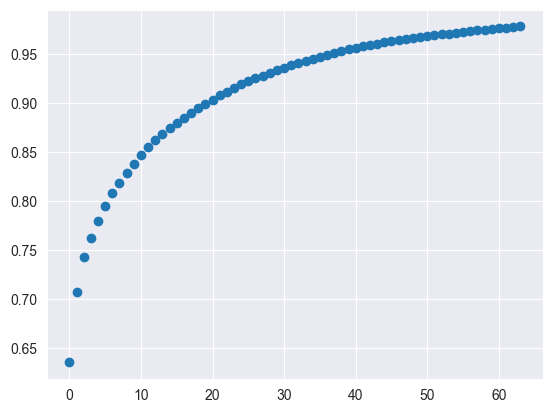

In [20]:
# CLS_LNS and Hist

X_train_cls_lns_hist, X_test_cls_lns_hist, my_pca = apply_pca(X_train3, X_test3, my_n_components=64)

y_train_cls_lns_hist = y_train3
y_test_cls_lns_hist = y_test3

plt.scatter(np.arange(64), np.cumsum(my_pca.explained_variance_ratio_))
plt.show()


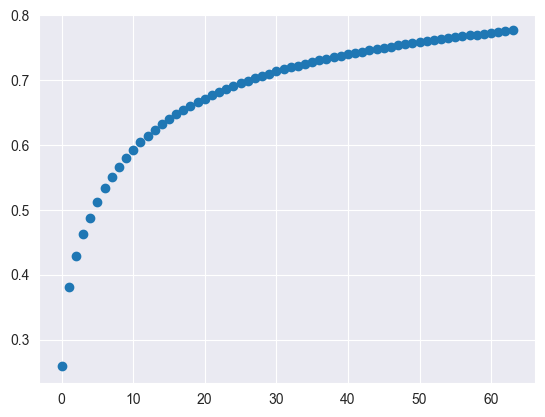

In [21]:
# FOURIER
X_train_Fourier, X_test_Fourier, my_pca = apply_pca(X_train_Fourier, X_test_Fourier, my_n_components=64)

plt.scatter(np.arange(64), np.cumsum(my_pca.explained_variance_ratio_))
plt.show()


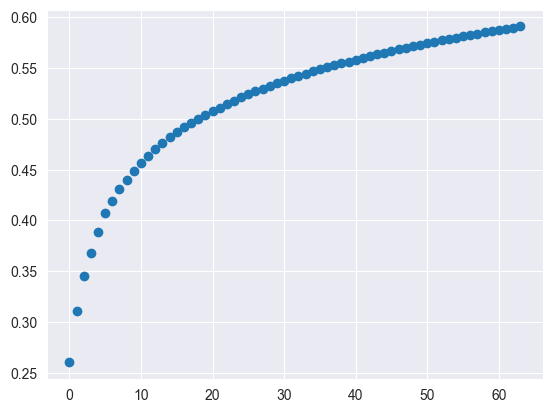

In [22]:
# SOBEL
X_train_Sobel, X_test_Sobel, my_pca = apply_pca(X_train_Sobel, X_test_Sobel, my_n_components=64)

plt.scatter(np.arange(64), np.cumsum(my_pca.explained_variance_ratio_))
plt.show()

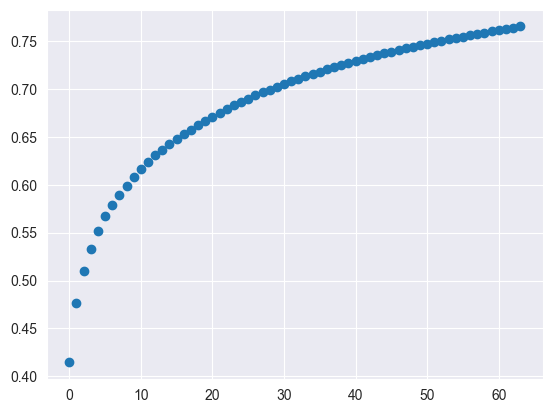

In [23]:
# HIST_SOBEL
X_train_Hist_Sobel, X_test_Hist_Sobel, my_pca = apply_pca(X_train_Hist_Sobel, X_test_Hist_Sobel, my_n_components=64)

plt.scatter(np.arange(64), np.cumsum(my_pca.explained_variance_ratio_))
plt.show()

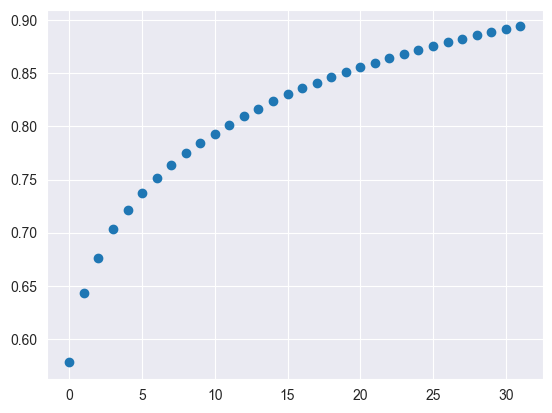

In [24]:
# Fourier_Hist
X_train_Fourier_Hist, X_test_Fourier_Hist, my_pca = apply_pca(X_train_Fourier_Hist,X_test_Fourier_Hist,my_n_components=32)

plt.scatter(np.arange(32),np.cumsum(my_pca.explained_variance_ratio_))
plt.show()

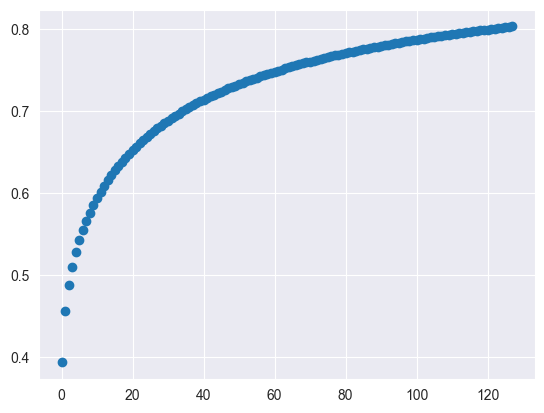

In [25]:
# All

X_train_all, X_test_all, my_pca = apply_pca(X_train_all, X_test_all, my_n_components=128)

plt.scatter(np.arange(128), np.cumsum(my_pca.explained_variance_ratio_))
plt.show()

# RUN ON DATA SET WITH LINES AND CIRCLES 

#### SVM

In [26]:
best_score = 0
best_params = {"loss": None, "penalty": None}

# options for loss and penalty  
losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

## OneVsOneClassifier - SVM
print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, dual="auto")).fit(
                X_train1,
                y_train1)
            pred_svm = svm.predict(X_test1)
            accuracy = accuracy_score(y_test1, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_score:
                best_score = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty

        except Exception as e:
            print(f"error: ${e}")

OneVsOneClassifier
error: $Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
hinge l2 57.4 %
squared_hinge l1 63.91 %
squared_hinge l2 63.91 %


In [27]:

svm1 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(
    X_train1, y_train1)
pred_svm1 = svm1.predict(X_test1)
confusion_Matrix(confusion_matrix(y_test1, pred_svm1))
print(classification_report(y_test1, pred_svm1))
accuracy = accuracy_score(y_test1, pred_svm1)
print(round(accuracy, 4) * 100, "%")
results.append(['lines and circles', 'SVM', round(np.sum([y_test1 == pred_svm1]) / len(y_test1), 4) * 100])

ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

#### KNN

In [ ]:
# Define the range of n_neighbors values
n_neighbors_values = range(1, 51)

# Initialize the best accuracy and best n_neighbors
best_accuracy = 0
best_n_neighbors = 0
# Loop over all possible n_neighbors values
for n_neighbors in n_neighbors_values:
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(X_train1, y_train1)
    pred_knn = neigh.predict(X_test1)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test1, pred_knn)  # That replaces the np.sum([y_test1==pred_knn])/len(y_test1)

    # If this accuracy is better than the best seen so far, update the best accuracy and best n_neighbors
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_neighbors = n_neighbors

    # print(n_neighbors,round(np.sum([y_test1==pred_knn])/len(y_test1),4)*100,"%")
    print(n_neighbors, round(accuracy, 4) * 100, "%")

In [ ]:
neigh1 = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh1.fit(X_train1, y_train1)
pred_knn1 = neigh1.predict(X_test1)
confusion_Matrix(confusion_matrix(y_test1, pred_knn1))
print(classification_report(y_test1, pred_knn1))
accuracy = accuracy_score(y_test1, pred_knn1)
print(round(accuracy, 4) * 100, "%")
results.append(['lines and circles', 'KNN', round(np.sum([y_test1 == pred_knn1]) / len(y_test1), 4) * 100])

#### Adaboost

In [ ]:
best_adaboost_accuracy = 0
best_adaboost_n_estimators = 0
for idx in range(50, 2001, 50):
    ada = AdaBoostClassifier(n_estimators=idx, algorithm="SAMME", random_state=0)
    ada.fit(X_train1, y_train1)
    pred_ada = ada.predict(X_test1)
    accuracy = accuracy_score(y_test1, pred_ada)
    print(idx, round(accuracy, 4) * 100, "%")
    if accuracy > best_adaboost_accuracy:
        best_adaboost_accuracy = accuracy
        best_adaboost_n_estimators = idx


In [ ]:
ada1 = AdaBoostClassifier(n_estimators=best_adaboost_n_estimators, algorithm="SAMME", random_state=0)
ada1.fit(X_train1, y_train1)
pred_ada1 = ada1.predict(X_test1)
confusion_Matrix(confusion_matrix(y_test1, pred_ada1))
print(classification_report(y_test1, pred_ada1))
accuracy = accuracy_score(y_test1, pred_ada1)
print(round(accuracy, 4) * 100, "%")

results.append(['lines and circles', 'Adaboost', round(np.sum([y_test1 == pred_ada1]) / len(y_test1), 4) * 100])

#### Random Forest

In [ ]:
best_rand_forest_accuracy = 0
best_n_estimators = 0

for curr_estimator in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=curr_estimator, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train1, y_train1)
        pred_RF = RF.predict(X_test1)
        accuracy = accuracy_score(y_test1, pred_RF)
        print(curr_estimator, j, round(accuracy, 4) * 100, "%")
        if accuracy > best_rand_forest_accuracy:
            best_rand_forest_accuracy = accuracy
            best_n_estimators = curr_estimator

In [ ]:
RF1 = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=3, random_state=0)
RF1.fit(X_train1, y_train1)
pred_RF1 = RF1.predict(X_test1)
confusion_Matrix(confusion_matrix(y_test1, pred_RF1))
print(classification_report(y_test1, pred_RF1))
print(round(np.sum([y_test1 == pred_RF1]) / len(y_test1), 4) * 100, "%")
results.append(['lines and circles', 'Random Forest', round(np.sum([y_test1 == pred_RF1]) / len(y_test1), 4) * 100])

#### Logistic Regression

In [ ]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train1, y_train1)
                pred_LR = LR.predict(X_test1)
                accuracy = accuracy_score(y_test1, pred_LR)
                print(p, s, t, round(accuracy, 4) * 100, "%")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params["penalty"] = p
                    best_params["solver"] = s
                    best_params["tol"] = t
            except Exception as e:
                print(f"error: ${e}")


In [ ]:
LR1 = LogisticRegression(penalty=best_params["penalty"], solver=best_params["solver"], tol=best_params["tol"], max_iter=10000, random_state=0)
LR1.fit(X_train1, y_train1)
pred_LR1 = LR1.predict(X_test1)
confusion_Matrix(confusion_matrix(y_test1, pred_LR1))
print(classification_report(y_test1, pred_LR1))
print(round(np.sum([y_test1 == pred_LR1]) / len(y_test1), 4) * 100, "%")
results.append(
    ['lines and circles', 'Logistic Regression', round(np.sum([y_test1 == pred_LR1]) / len(y_test1), 4) * 100])

# RUN ON DATA SET WITH HISTOGRAM DATA

#### SVM

In [51]:
best_score = 0
best_params = {"loss": None, "penalty": None}

losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, )).fit(X_train2,
                                                                                                        y_train2)
            pred_svm = svm.predict(X_test2)
            accuracy = accuracy_score(y_test2, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_score:
                best_score = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty
        except Exception as e:
            print(f"error: ${e}")




OneVsOneClassifier
error: $Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
hinge l2 58.879999999999995 %
error: $Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
squared_hinge l2 58.879999999999995 %


              precision    recall  f1-score   support

           0       0.55      0.85      0.67       166
           1       0.70      0.34      0.45       172

    accuracy                           0.59       338
   macro avg       0.63      0.59      0.56       338
weighted avg       0.63      0.59      0.56       338

58.879999999999995 %


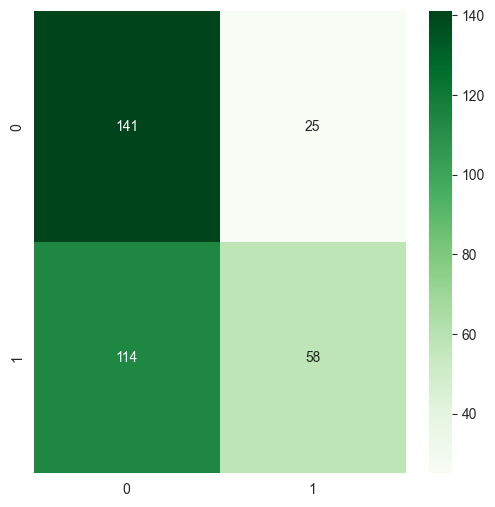

In [52]:
svm2 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(
    X_train2, y_train2)
pred_svm2 = svm2.predict(X_test2)
confusion_Matrix(confusion_matrix(y_test2, pred_svm2))
print(classification_report(y_test2, pred_svm2))
print(round(np.sum([y_test2 == pred_svm2]) / len(y_test2), 4) * 100, "%")
results.append(['histogram', 'SVM', round(np.sum([y_test2 == pred_svm2]) / len(y_test2), 4) * 100])

#### KNN

In [53]:
best_n_neighbors = 0
best_accuracy = 0
for curr_n_neighbors in range(1, 51):
    neigh = KNeighborsClassifier(n_neighbors=curr_n_neighbors)
    neigh.fit(X_train2, y_train2)
    pred_knn = neigh.predict(X_test2)
    accuracy = accuracy_score(y_test2, pred_knn)
    print(curr_n_neighbors, round(accuracy, 4) * 100, "%")
    # If this accuracy is better than the best seen so far, update the best accuracy and best n_neighbors
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_neighbors = curr_n_neighbors

1 63.31 %
2 58.879999999999995 %
3 64.2 %
4 63.019999999999996 %
5 68.05 %
6 62.129999999999995 %
7 65.98 %
8 65.38000000000001 %
9 67.75 %
10 63.91 %
11 66.27 %
12 64.5 %
13 65.98 %
14 65.09 %
15 68.34 %
16 65.68 %
17 67.46 %
18 66.86 %
19 67.46 %
20 66.27 %
21 67.16 %
22 64.2 %
23 66.57 %
24 65.38000000000001 %
25 68.05 %
26 65.68 %
27 66.86 %
28 63.91 %
29 64.79 %
30 64.5 %
31 64.79 %
32 63.91 %
33 65.68 %
34 64.5 %
35 64.5 %
36 63.61 %
37 64.2 %
38 64.2 %
39 63.31 %
40 63.61 %
41 65.38000000000001 %
42 65.09 %
43 64.2 %
44 63.91 %
45 63.61 %
46 63.31 %
47 63.019999999999996 %
48 63.31 %
49 63.019999999999996 %
50 62.43 %


              precision    recall  f1-score   support

           0       0.64      0.81      0.72       166
           1       0.76      0.56      0.64       172

    accuracy                           0.68       338
   macro avg       0.70      0.69      0.68       338
weighted avg       0.70      0.68      0.68       338

68.34 %


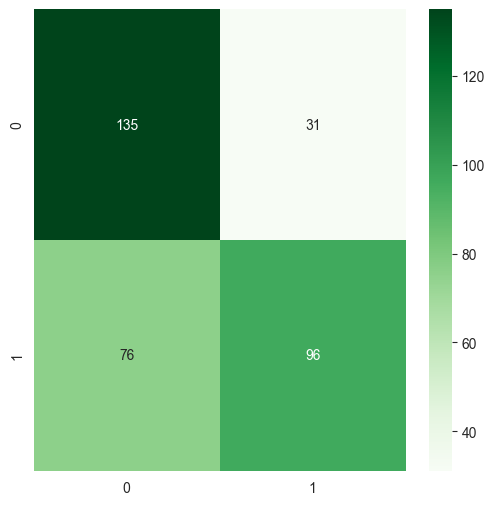

In [54]:
neigh2 = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh2.fit(X_train2, y_train2)
pred_knn2 = neigh2.predict(X_test2)
confusion_Matrix(confusion_matrix(y_test2, pred_knn2))
print(classification_report(y_test2, pred_knn2))
print(round(np.sum([y_test2 == pred_knn2]) / len(y_test2), 4) * 100, "%")
results.append(['histogram', 'KNN', round(np.sum([y_test2 == pred_knn2]) / len(y_test2), 4) * 100])

#### Adaboost

In [ ]:
best_adaboost_accuracy = 0
best_adaboost_n_estimators = 0
for idx in range(50, 2001, 50):
    ada = AdaBoostClassifier(n_estimators=idx, algorithm="SAMME", random_state=0)
    ada.fit(X_train2, y_train2)
    pred_ada = ada.predict(X_test2)
    accuracy = accuracy_score(y_test2, pred_ada)
    print(idx, round(accuracy, 4) * 100, "%")
    if accuracy > best_adaboost_accuracy:
        best_adaboost_accuracy = accuracy
        best_adaboost_n_estimators = idx

50 67.75 %
100 71.00999999999999 %
150 70.12 %
200 69.53 %
250 70.71 %
300 71.6 %
350 70.41 %
400 72.19 %
450 71.6 %
500 71.3 %
550 71.3 %
600 70.12 %
650 71.89 %
700 72.19 %
750 71.6 %
800 71.6 %
850 72.49 %


In [ ]:
ada2 = AdaBoostClassifier(n_estimators=best_adaboost_n_estimators, algorithm="SAMME", random_state=0)
ada2.fit(X_train2, y_train2)
pred_ada2 = ada2.predict(X_test2)
confusion_Matrix(confusion_matrix(y_test2, pred_ada2))
print(classification_report(y_test2, pred_ada2))
print(round(np.sum([y_test2 == pred_ada2]) / len(y_test2), 4) * 100, "%")
results.append(['histogram', 'Adaboost', round(np.sum([y_test2 == pred_ada2]) / len(y_test2), 4) * 100])

#### Random Forset

In [ ]:
best_rand_forest_accuracy = 0
best_n_estimators = 0

for i in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train2, y_train2)
        pred_RF = RF.predict(X_test2)
        accuracy = accuracy_score(y_test2, pred_RF)
        print(i, j, round(np.sum([y_test2 == pred_RF]) / len(y_test2), 4) * 100, "%")
        if accuracy > best_rand_forest_accuracy:
            best_rand_forest_accuracy = accuracy
            best_n_estimators = i

In [ ]:
RF2 = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=3, random_state=0)
RF2.fit(X_train2, y_train2)
pred_RF2 = RF2.predict(X_test2)
confusion_Matrix(confusion_matrix(y_test2, pred_RF2))
print(classification_report(y_test2, pred_RF2))
print(round(np.sum([y_test2 == pred_RF2]) / len(y_test2), 4) * 100, "%")
results.append(['histogram', 'Random Forest', round(np.sum([y_test2 == pred_RF2]) / len(y_test2), 4) * 100])

#### Logistic Regression

In [ ]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train2, y_train2)
                pred_LR = LR.predict(X_test2)
                accuracy = accuracy_score(y_test1, pred_LR)
                print(p, s, t, round(accuracy, 4) * 100, "%")
                if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params["penalty"] = p
                        best_params["solver"] = s
                        best_params["tol"] = t
            except Exception as e:
                print(f"Error: ${e}")


In [ ]:
LR2 =  LogisticRegression(penalty=best_params["penalty"], solver=best_params["solver"], tol=best_params["tol"], max_iter=10000, random_state=0)
LR2.fit(X_train2, y_train2)
pred_LR2 = LR2.predict(X_test2)
confusion_Matrix(confusion_matrix(y_test2, pred_LR2))
print(classification_report(y_test2, pred_LR2))
print(round(np.sum([y_test2 == pred_LR2]) / len(y_test2), 4) * 100, "%")
results.append(['histogram', 'Logistic Regression', round(np.sum([y_test2 == pred_LR2]) / len(y_test2), 4) * 100])

# RUN ON DATA SET WITH LINES, CIRCLES AND HISTOGRAM DATA

#### SVM

In [ ]:
losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for i in losses:
    for j in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=i, penalty=j, )).fit(X_train3, y_train3)
            pred_svm = svm.predict(X_test3)
            print(i, j, round(np.sum([y_test3 == pred_svm]) / len(y_test3), 4) * 100, "%")
        except Exception as e:
            print(f"error: ${e}")






In [ ]:
svm3 = OneVsOneClassifier(LinearSVC(random_state=0, loss="hinge", penalty="l2")).fit(X_train3, y_train3)
pred_svm3 = svm3.predict(X_test3)
confusion_Matrix(confusion_matrix(y_test3, pred_svm3))
print(classification_report(y_test3, pred_svm3))
print(round(np.sum([y_test3 == pred_svm3]) / len(y_test3), 4) * 100, "%")
results.append(['lines, circle, and histogram', 'SVM', round(np.sum([y_test3 == pred_svm3]) / len(y_test3), 4) * 100])

#### KNN

In [ ]:
for i in range(3, 101, 2):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train3, y_train3)
    pred_knn = neigh.predict(X_test3)
    print(i, round(np.sum([y_test3 == pred_knn]) / len(y_test3), 4) * 100, "%")


In [ ]:
neigh3 = KNeighborsClassifier(n_neighbors=3)
neigh3.fit(X_train3, y_train3)
pred_knn3 = neigh3.predict(X_test3)
confusion_Matrix(confusion_matrix(y_test3, pred_knn3))
print(classification_report(y_test3, pred_knn3))
print(round(np.sum([y_test3 == pred_knn3]) / len(y_test3), 4) * 100, "%")
results.append(['lines, circle, and histogram', 'KNN', round(np.sum([y_test3 == pred_knn3]) / len(y_test3), 4) * 100])

#### ADABOOST

In [ ]:
for i in range(50, 2001, 50):
    ada = AdaBoostClassifier(n_estimators=i, algorithm="SAMME", random_state=0)
    ada.fit(X_train3, y_train3)
    pred_ada = ada.predict(X_test3)
    print(i, round(np.sum([y_test3 == pred_ada]) / len(y_test3), 4) * 100, "%")

In [ ]:
ada3 = AdaBoostClassifier(n_estimators=250, algorithm="SAMME", random_state=0)
ada3.fit(X_train3, y_train3)
pred_ada3 = ada3.predict(X_test3)
confusion_Matrix(confusion_matrix(y_test3, pred_ada3))
print(classification_report(y_test3, pred_ada3))
print(round(np.sum([y_test3 == pred_ada3]) / len(y_test3), 4) * 100, "%")
results.append(
    ['lines, circle, and histogram', 'Adaboost', round(np.sum([y_test3 == pred_ada3]) / len(y_test3), 4) * 100])

#### RANDOM FOREST

In [ ]:
for i in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train3, y_train3)
        pred_RF = RF.predict(X_test3)
        print(i, j, round(np.sum([y_test3 == pred_RF]) / len(y_test3), 4) * 100, "%")

In [ ]:
RF3 = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=4, random_state=0)
RF3.fit(X_train3, y_train3)
pred_RF3 = RF3.predict(X_test3)
confusion_Matrix(confusion_matrix(y_test3, pred_RF3))
print(classification_report(y_test3, pred_RF3))
print(round(np.sum([y_test3 == pred_RF3]) / len(y_test3), 4) * 100, "%")
results.append(
    ['lines, circle, and histogram', 'Random Forest', round(np.sum([y_test3 == pred_RF3]) / len(y_test3), 4) * 100])

#### LOGISTIC REGRESSION

In [ ]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train3, y_train3)
                pred_LR = LR.predict(X_test3)
                print(p, s, t, round(np.sum([y_test3 == pred_LR]) / len(y_test3), 4) * 100, "%")
            except Exception as e:
                print(f"Error: ${e}")

In [ ]:
LR3 = LogisticRegression(penalty="l1", solver="liblinear", tol=0.1, max_iter=10000, random_state=0)
LR3.fit(X_train3, y_train3)
pred_LR3 = LR3.predict(X_test3)
confusion_Matrix(confusion_matrix(y_test3, pred_LR3))
print(classification_report(y_test3, pred_LR3))
print(round(np.sum([y_test3 == pred_LR3]) / len(y_test3), 4) * 100, "%")
results.append(['lines, circle, and histogram', 'Logistic Regression',
                round(np.sum([y_test3 == pred_LR3]) / len(y_test3), 4) * 100])

# RUN ON LINES CIRCLES AND HIST WITH PCA

#### SVM

In [ ]:
best_accuracy = 0
best_params = {"loss": None, "penalty": None}

losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, dual="auto")).fit(
                X_train_cls_lns_hist, y_train_cls_lns_hist)
            pred_svm = svm.predict(X_test_cls_lns_hist)
            accuracy = accuracy_score(y_test_cls_lns_hist, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty
        except Exception as e:
            print(f"Error with loss={my_loss} and penalty={my_penalty}: {e}")



In [ ]:
svm4 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(
    X_train_cls_lns_hist, y_train_cls_lns_hist)
pred_svm4 = svm4.predict(X_test_cls_lns_hist)
confusion_Matrix(confusion_matrix(y_test_cls_lns_hist, pred_svm4))
print(classification_report(y_test_cls_lns_hist, pred_svm4))
print(round(np.sum([y_test_cls_lns_hist == pred_svm4]) / len(y_test_cls_lns_hist), 4) * 100, "%")
results.append(
    ['lines, circle, and histogram PCA', 'SVM',
     round(np.sum([y_test_cls_lns_hist == pred_svm4]) / len(y_test_cls_lns_hist), 4) * 100])

#### KNN

In [ ]:
for i in range(1, 51):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
    pred_knn = neigh.predict(X_test_cls_lns_hist)
    print(i, round(np.sum([y_test_cls_lns_hist == pred_knn]) / len(y_test_cls_lns_hist), 4) * 100, "%")

In [ ]:
neigh4 = KNeighborsClassifier(n_neighbors=1)
neigh4.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
pred_knn4 = neigh4.predict(X_test_cls_lns_hist)
confusion_Matrix(confusion_matrix(y_test_cls_lns_hist, pred_knn4))
print(classification_report(y_test_cls_lns_hist, pred_knn4))
print(round(np.sum([y_test_cls_lns_hist == pred_knn4]) / len(y_test_cls_lns_hist), 4) * 100, "%")
results.append(
    ['lines, circle, and histogram PCA 0.99', 'KNN',
     round(np.sum([y_test_cls_lns_hist == pred_knn4]) / len(y_test_cls_lns_hist), 4) * 100])

#### Adaboost

In [ ]:
for i in range(50, 2001, 50):
    ada = AdaBoostClassifier(n_estimators=i, algorithm="SAMME", random_state=0)
    ada.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
    pred_ada = ada.predict(X_test_cls_lns_hist)
    print(i, round(np.sum([y_test_cls_lns_hist == pred_ada]) / len(y_test_cls_lns_hist), 4) * 100, "%")

In [ ]:
ada4 = AdaBoostClassifier(n_estimators=600, algorithm="SAMME", random_state=0)
ada4.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
pred_ada4 = ada4.predict(X_test_cls_lns_hist)
confusion_Matrix(confusion_matrix(y_test_cls_lns_hist, pred_ada4))
print(classification_report(y_test_cls_lns_hist, pred_ada4))
print(round(np.sum([y_test_cls_lns_hist == pred_ada4]) / len(y_test_cls_lns_hist), 4) * 100, "%")
results.append(['lines, circle, and histogram PCA 0.99', 'Adaboost',
                round(np.sum([y_test_cls_lns_hist == pred_ada4]) / len(y_test_cls_lns_hist), 4) * 100])

#### Random Forest

In [ ]:
for i in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
        pred_RF = RF.predict(X_test_cls_lns_hist)
        print(i, j, round(np.sum([y_test_cls_lns_hist == pred_RF]) / len(y_test_cls_lns_hist), 4) * 100, "%")

In [ ]:
RF4 = RandomForestClassifier(n_estimators=460, max_depth=None, min_samples_split=3, random_state=0)
RF4.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
pred_RF4 = RF4.predict(X_test_cls_lns_hist)
confusion_Matrix(confusion_matrix(y_test_cls_lns_hist, pred_RF4))
print(classification_report(y_test_cls_lns_hist, pred_RF4))
print(round(np.sum([y_test_cls_lns_hist == pred_RF4]) / len(y_test_cls_lns_hist), 4) * 100, "%")
results.append(['lines, circle, and histogram PCA 0.99', 'Random Forest',
                round(np.sum([y_test_cls_lns_hist == pred_RF4]) / len(y_test_cls_lns_hist), 4) * 100])

#### Logistic Regression

In [ ]:
penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for i in penalties:
    for j in solvers:
        for k in tols:
            try:
                LR = LogisticRegression(penalty=i, solver=j, tol=k, max_iter=10000, random_state=0)
                LR.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
                pred_LR = LR.predict(X_test_cls_lns_hist)
                print(i, j, k, round(np.sum([y_test_cls_lns_hist == pred_LR]) / len(y_test_cls_lns_hist), 4) * 100, "%")
            except Exception as e:
                print(f"Error: ${e}")

In [ ]:
LR4 = LogisticRegression(penalty="l1", solver="liblinear", tol=0.1, max_iter=10000, random_state=0)
LR4.fit(X_train_cls_lns_hist, y_train_cls_lns_hist)
pred_LR4 = LR4.predict(X_test_cls_lns_hist)
confusion_Matrix(confusion_matrix(y_test_cls_lns_hist, pred_LR4))
print(classification_report(y_test_cls_lns_hist, pred_LR4))
print(round(np.sum([y_test_cls_lns_hist == pred_LR4]) / len(y_test_cls_lns_hist), 4) * 100, "%")
results.append(['lines, circle, and histogram PCA', 'Logistic Regression',
                round(np.sum([y_test_cls_lns_hist == pred_LR4]) / len(y_test_cls_lns_hist), 4) * 100])

In [ ]:
    # cols = ["df_type", "classifier", "accuracy"]
# df = pd.DataFrame(results, columns=cols)

In [ ]:
# # df
# 
# filenames = ['svm1.sav', 'svm2.sav', 'svm3.sav', 'svm4.sav', 'knn1.sav', 'knn2.sav', 'knn3.sav', 'knn4.sav',
#              'ada1.sav', 'ada2.sav', 'ada3.sav', 'ada4.sav', 'RF1.sav', 'RF2.sav', 'RF3.sav', 'RF4.sav',
#              'LR1.sav', 'LR2.sav', 'LR3.sav', 'LR4.sav']
# models = [svm1, svm2, svm3, svm4, neigh1, neigh2, neigh3, neigh4,
#           ada1, ada2, ada3, ada4, RF1, RF2, RF3, RF4, LR1, LR2, LR3, LR4]
# 
# for i in range(len(filenames)):
#     pickle.dump(models[i], open(filenames[i], 'wb'))

In [ ]:
# svm3 = pickle.load(open('svm3.sav', 'rb'))
# neigh3 = pickle.load(open('knn3.sav', 'rb'))
# ada3 = pickle.load(open('ada3.sav', 'rb'))
# RF3 = pickle.load(open('RF3.sav', 'rb'))
# LR3 = pickle.load(open('LR3.sav', 'rb'))

In [ ]:
# combo model

# weights = [47.61, 49.57, 61.09, 68.48, 56.74]
# normalizer = 1 / float(sum(weights))
# for i in range(len(weights)):
#     weights[i] = normalizer * weights[i]
# # print(weights)
# 
# 
# svm3.fit(X_train3, y_train3)
# pred_svm3 = svm3.predict(X_test3)
# 
# neigh3.fit(X_train3, y_train3)
# pred_knn3 = neigh3.predict(X_test3)
# 
# ada3.fit(X_train3, y_train3)
# pred_ada3 = ada3.predict(X_test3)
# 
# RF3.fit(X_train3, y_train3)
# pred_RF3 = RF3.predict(X_test3)
# 
# LR3.fit(X_train3, y_train3)
# pred_LR3 = LR3.predict(X_test3)


In [ ]:


# def find_best(l, weight):
#     classes = [0] * 12
#     ws = [0] * 12
#     for i in range(len(l)):
#         classes[l[i]] += 1
#         ws[l[i]] += weight[i]
# 
#     best = -1
#     maxx = -1
#     for i in range(len(ws)):
#         if ws[i] > maxx:
#             maxx = ws[i]
#             best = i
#     return best
# 
# 
# 


In [ ]:
# over_all = []
# preds = [pred_svm3, pred_knn3, pred_ada3, pred_RF3, pred_LR3]
# for i in range(len(y_test3)):
#     p = []
#     for j in preds:
#         p.append(j[i])
#     over_all.append(p)
# 
# final_pred = []
# for i in over_all:
#     c = find_best(i, weights)
#     final_pred.append(c)
#     print(i, c)
# # print(final_pred)

In [ ]:
# confusion_Matrix(confusion_matrix(y_test3, final_pred))
# print(classification_report(y_test3, final_pred))
# print(round(np.sum([y_test3 == final_pred]) / len(y_test3), 4) * 100, "%")
# # results.append(['lines, circle, and histogram PCA 0.99', 'Logistic Regression',round(np.sum([y_test_cls_lns_hist==pred_LR4])/len(y_test_cls_lns_hist),4)*100 ])

## Run on Fourier Transform using PCA

#### Creating new df from the Foruier Transform PCA

In [ ]:

# create new df
cols = [i for i in range(64)]
df_Fourier = pd.DataFrame(X_train_Fourier, columns=cols)
cy = []
for i in y_train_Fourier:
    cy.append(i)
df_Fourier['class_number'] = cy
df_Fourier.to_csv('df_Fourier.csv', index=False)


#### SVM

In [ ]:
best_score = 0
best_params = {"loss": None, "penalty": None}

losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, )).fit(X_train_Fourier,
                                                                                                        y_train_Fourier)
            pred_svm = svm.predict(X_test_Fourier)
            accuracy = accuracy_score(y_test_Fourier, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_score:
                best_score = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty
        except Exception as e:
            print(f"error: ${e}")
            

In [ ]:
svm5 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(
    X_train_Fourier, y_train_Fourier)
pred_svm5 = svm5.predict(X_test_Fourier)
confusion_Matrix(confusion_matrix(y_test_Fourier, pred_svm5))
print(classification_report(y_test_Fourier, pred_svm5))
print(round(np.sum([y_test_Fourier == pred_svm5]) / len(y_test_Fourier), 4) * 100, "%")
results.append(['Fourier Transform PCA', 'SVM', round(np.sum([y_test_Fourier == pred_svm5]) / len(y_test_Fourier), 4) * 100])

### KNN

In [ ]:
best_n_neighbors = 0
best_accuracy = 0

for curr_n_neighbors in range(1, 51):
    try:
        neigh = KNeighborsClassifier(n_neighbors=curr_n_neighbors)
        neigh.fit(X_train_Fourier, y_train_Fourier)
        pred_knn = neigh.predict(X_test_Fourier)
        accuracy = accuracy_score(y_test_Fourier, pred_knn)
        print(curr_n_neighbors, round(accuracy, 4) * 100, "%")
        # If this accuracy is better than the best seen so far, update the best accuracy and best n_neighbors
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = curr_n_neighbors
    except Exception as e:
        print(f"Error: ${e}")

In [28]:
neigh5 = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh5.fit(X_train_Fourier, y_train_Fourier)
pred_knn5 = neigh5.predict(X_test_Fourier)
confusion_Matrix(confusion_matrix(y_test_Fourier, pred_knn5))
print(classification_report(y_test_Fourier, pred_knn5))
print(round(np.sum([y_test_Fourier == pred_knn5]) / len(y_test_Fourier), 4) * 100, "%")
results.append(['Fourier Transform PCA', 'KNN', round(np.sum([y_test_Fourier == pred_knn5]) / len(y_test_Fourier), 4) * 100])

NameError: name 'best_n_neighbors' is not defined

### Adaboost

In [ ]:
best_adaboost_accuracy = 0
best_adaboost_n_estimators = 0
for idx in range(50, 2001, 50):
    try:
        ada = AdaBoostClassifier(n_estimators=idx, algorithm="SAMME", random_state=0)
        ada.fit(X_train_Fourier, y_train_Fourier)
        pred_ada = ada.predict(X_test_Fourier)
        accuracy = accuracy_score(y_test_Fourier, pred_ada)
        print(idx, round(accuracy, 4) * 100, "%")
        if accuracy > best_adaboost_accuracy:
            best_adaboost_accuracy = accuracy
            best_adaboost_n_estimators = idx
    except Exception as e:
        print(f"Error: ${e}")
        

In [ ]:
ada5 = AdaBoostClassifier(n_estimators=best_adaboost_n_estimators, algorithm="SAMME", random_state=0)
ada5.fit(X_train_Fourier, y_train_Fourier)
pred_ada5 = ada5.predict(X_test_Fourier)
confusion_Matrix(confusion_matrix(y_test_Fourier, pred_ada5))
print(classification_report(y_test_Fourier, pred_ada5))
print(round(np.sum([y_test_Fourier == pred_ada5]) / len(y_test_Fourier), 4) * 100, "%")
results.append(['Fourier Transform PCA', 'Adaboost', round(np.sum([y_test_Fourier == pred_ada5]) / len(y_test_Fourier), 4) * 100])


### Random Forest


In [ ]:
best_rand_forest_accuracy = 0
best_n_estimators = 0

for curr_estimator in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=curr_estimator, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train_Fourier, y_train_Fourier)
        pred_RF = RF.predict(X_test_Fourier)
        accuracy = accuracy_score(y_test_Fourier, pred_RF)
        print(curr_estimator, j, round(np.sum([y_test_Fourier == pred_RF]) / len(y_test_Fourier), 4) * 100, "%")
        if accuracy > best_rand_forest_accuracy:
            best_rand_forest_accuracy = accuracy
            best_n_estimators = curr_estimator

In [ ]:
RF5 = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=3, random_state=0)
RF5.fit(X_train_Fourier, y_train_Fourier)
pred_RF5 = RF5.predict(X_test_Fourier)
confusion_Matrix(confusion_matrix(y_test_Fourier, pred_RF5))
print(classification_report(y_test_Fourier, pred_RF5))
print(round(np.sum([y_test_Fourier == pred_RF5]) / len(y_test_Fourier), 4) * 100, "%")
results.append(['Fourier Transform PCA', 'Random Forest', round(np.sum([y_test_Fourier == pred_RF5]) / len(y_test_Fourier), 4) * 100])


### Logistic Regression


In [ ]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train_Fourier, y_train_Fourier)
                pred_LR = LR.predict(X_test_Fourier)
                accuracy = accuracy_score(y_test_Fourier, pred_LR)
                print(p, s, t, round(accuracy, 4) * 100, "%")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params["penalty"] = p
                    best_params["solver"] = s
                    best_params["tol"] = t
            except Exception as e:
                print(f"Error: ${e}")
                

In [ ]:
LR5 = LogisticRegression(penalty=best_params["penalty"], solver=best_params["solver"], tol=best_params["tol"], max_iter=10000, random_state=0)
LR5.fit(X_train_Fourier, y_train_Fourier)
pred_LR5 = LR5.predict(X_test_Fourier)
confusion_Matrix(confusion_matrix(y_test_Fourier, pred_LR5))
print(classification_report(y_test_Fourier, pred_LR5))
print(round(np.sum([y_test_Fourier == pred_LR5]) / len(y_test_Fourier), 4) * 100, "%")
results.append(['Fourier Transform PCA', 'Logistic Regression', round(np.sum([y_test_Fourier == pred_LR5]) / len(y_test_Fourier), 4) * 100])

### Run on Sobel edges using PCA


In [ ]:
#creating new df

cols = [i for i in range(64)]
df_Sobel = pd.DataFrame(X_train_Sobel, columns=cols)
cy = []
for i in y_train_Sobel:
    cy.append(i)
df_Sobel['class_number'] = cy
df_Sobel.to_csv('df_Sobel.csv', index=False)


#### SVM


In [ ]:
best_score = 0
best_params = {"loss": None, "penalty": None}

losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, )).fit(X_train_Sobel,
                                                                                                        y_train_Sobel)
            pred_svm = svm.predict(X_test_Sobel)
            accuracy = accuracy_score(y_test_Sobel, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_score:
                best_score = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty
        except Exception as e:
            print(f"error: ${e}")
            
            

In [ ]:
svm6 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(
    X_train_Sobel, y_train_Sobel)
pred_svm6 = svm6.predict(X_test_Sobel)
confusion_Matrix(confusion_matrix(y_test_Sobel, pred_svm6))
print(classification_report(y_test_Sobel, pred_svm6))
print(round(np.sum([y_test_Sobel == pred_svm6]) / len(y_test_Sobel), 4) * 100, "%")
results.append(['Sobel edges PCA', 'SVM', round(np.sum([y_test_Sobel == pred_svm6]) / len(y_test_Sobel), 4) * 100])

#### KNN

In [ ]:
best_n_neighbors = 0
best_accuracy = 0

for curr_n_neighbors in range(1, 51):
    try:
        neigh = KNeighborsClassifier(n_neighbors=curr_n_neighbors)
        neigh.fit(X_train_Sobel, y_train_Sobel)
        pred_knn = neigh.predict(X_test_Sobel)
        accuracy = accuracy_score(y_test_Sobel, pred_knn)
        print(curr_n_neighbors, round(accuracy, 4) * 100, "%")
        # If this accuracy is better than the best seen so far, update the best accuracy and best n_neighbors
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = curr_n_neighbors
    except Exception as e:
        print(f"Error: ${e}")
        

In [ ]:
neigh6 = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh6.fit(X_train_Sobel, y_train_Sobel)
pred_knn6 = neigh6.predict(X_test_Sobel)

confusion_Matrix(confusion_matrix(y_test_Sobel, pred_knn6))
print(classification_report(y_test_Sobel, pred_knn6))
print(round(np.sum([y_test_Sobel == pred_knn6]) / len(y_test_Sobel), 4) * 100, "%")
results.append(['Sobel edges PCA', 'KNN', round(np.sum([y_test_Sobel == pred_knn6]) / len(y_test_Sobel), 4) * 100])


#### Adaboost


In [ ]:
best_adaboost_accuracy = 0
best_adaboost_n_estimators = 0

for idx in range(50, 2001, 50):
    try:
        ada = AdaBoostClassifier(n_estimators=idx, algorithm="SAMME", random_state=0)
        ada.fit(X_train_Sobel, y_train_Sobel)
        pred_ada = ada.predict(X_test_Sobel)
        accuracy = accuracy_score(y_test_Sobel, pred_ada)
        print(idx, round(accuracy, 4) * 100, "%")
        if accuracy > best_adaboost_accuracy:
            best_adaboost_accuracy = accuracy
            best_adaboost_n_estimators = idx
    except Exception as e:
        print(f"Error: ${e}")
        

In [ ]:
ada6 = AdaBoostClassifier(n_estimators=best_adaboost_n_estimators, algorithm="SAMME", random_state=0)
ada6.fit(X_train_Sobel, y_train_Sobel)
pred_ada6 = ada6.predict(X_test_Sobel)
confusion_Matrix(confusion_matrix(y_test_Sobel, pred_ada6))
print(classification_report(y_test_Sobel, pred_ada6))
print(round(np.sum([y_test_Sobel == pred_ada6]) / len(y_test_Sobel), 4) * 100, "%")
results.append(['Sobel edges PCA', 'Adaboost', round(np.sum([y_test_Sobel == pred_ada6]) / len(y_test_Sobel), 4) * 100])


#### Random Forest


In [ ]:
best_rand_forest_accuracy = 0
best_n_estimators = 0

for curr_estimator in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=curr_estimator, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train_Sobel, y_train_Sobel)
        pred_RF = RF.predict(X_test_Sobel)
        accuracy = accuracy_score(y_test_Sobel, pred_RF)
        print(curr_estimator, j, round(accuracy, 4) * 100, "%")
        if accuracy > best_rand_forest_accuracy:
            best_rand_forest_accuracy = accuracy
            best_n_estimators = curr_estimator
            

In [ ]:
RF6 = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=3, random_state=0)
RF6.fit(X_train_Sobel, y_train_Sobel)
pred_RF6 = RF6.predict(X_test_Sobel)
confusion_Matrix(confusion_matrix(y_test_Sobel, pred_RF6))
print(classification_report(y_test_Sobel, pred_RF6))
print(round(np.sum([y_test_Sobel == pred_RF6]) / len(y_test_Sobel), 4) * 100, "%")
results.append(['Sobel edges PCA', 'Random Forest', round(np.sum([y_test_Sobel == pred_RF6]) / len(y_test_Sobel), 4) * 100])


#### Logistic Regression


In [ ]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train_Sobel, y_train_Sobel)
                pred_LR = LR.predict(X_test_Sobel)
                accuracy = accuracy_score(y_test_Sobel, pred_LR)
                print(p, s, t, round(accuracy, 4) * 100, "%")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params["penalty"] = p
                    best_params["solver"] = s
                    best_params["tol"] = t
            except Exception as e:
                print(f"Error: ${e}")
                

In [ ]:
LR6 = LogisticRegression(penalty=best_params["penalty"], solver=best_params["solver"], tol=best_params["tol"], max_iter=10000, random_state=0)

LR6.fit(X_train_Sobel, y_train_Sobel)
pred_LR6 = LR6.predict(X_test_Sobel)
confusion_Matrix(confusion_matrix(y_test_Sobel, pred_LR6))
print(classification_report(y_test_Sobel, pred_LR6))
print(round(np.sum([y_test_Sobel == pred_LR6]) / len(y_test_Sobel), 4) * 100, "%")
results.append(['Sobel edges PCA', 'Logistic Regression', round(np.sum([y_test_Sobel == pred_LR6]) / len(y_test_Sobel), 4) * 100])


## Run on sobel and histogram using PCA


In [ ]:
# creating new df

cols = [i for i in range(64)]
df_Sobel_hist = pd.DataFrame(X_train_Hist_Sobel, columns=cols)
cy = []
for i in y_train_Hist_Sobel:
    cy.append(i)
df_Sobel_hist['class_number'] = cy
df_Sobel_hist.to_csv('df_Sobel_hist.csv', index=False)


#### SVM


In [ ]:
best_score = 0
best_params = {"loss": None, "penalty": None}

losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, )).fit(X_train_Hist_Sobel,
                                                                                                        y_train_Hist_Sobel)
            pred_svm = svm.predict(X_test_Hist_Sobel)
            accuracy = accuracy_score(y_test_Hist_Sobel, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_score:
                best_score = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty
        except Exception as e:
            print(f"error: ${e}")
            

In [ ]:
svm7 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(
    X_train_Hist_Sobel, y_train_Hist_Sobel)
pred_svm7 = svm7.predict(X_test_Hist_Sobel)
confusion_Matrix(confusion_matrix(y_test_Hist_Sobel, pred_svm7))
print(classification_report(y_test_Hist_Sobel, pred_svm7))
print(round(np.sum([y_test_Hist_Sobel == pred_svm7]) / len(y_test_Hist_Sobel), 4) * 100, "%")
results.append(['Sobel and histogram PCA', 'SVM', round(np.sum([y_test_Hist_Sobel == pred_svm7]) / len(y_test_Hist_Sobel), 4) * 100])


#### KNN


In [ ]:
best_accuracy = 0
best_n_neighbors = 0

for curr_n_neighbors in range(1, 51):
    try:
        neigh = KNeighborsClassifier(n_neighbors=curr_n_neighbors)
        neigh.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
        pred_knn = neigh.predict(X_test_Hist_Sobel)
        accuracy = accuracy_score(y_test_Hist_Sobel, pred_knn)
        print(curr_n_neighbors, round(accuracy, 4) * 100, "%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = curr_n_neighbors
    except Exception as e:
        print(f"Error: ${e}")
        

In [ ]:
neigh7 = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh7.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
pred_knn7 = neigh7.predict(X_test_Hist_Sobel)
confusion_Matrix(confusion_matrix(y_test_Hist_Sobel, pred_knn7))
print(classification_report(y_test_Hist_Sobel, pred_knn7))
print(round(np.sum([y_test_Hist_Sobel == pred_knn7]) / len(y_test_Hist_Sobel), 4) * 100, "%")

results.append(['Sobel and histogram PCA', 'KNN', round(np.sum([y_test_Hist_Sobel == pred_knn7]) / len(y_test_Hist_Sobel), 4) * 100])


#### Adaboost


In [ ]:
best_adaboost_accuracy = 0
best_adaboost_n_estimators = 0

for idx in range(50, 2001, 50):
    try:
        ada = AdaBoostClassifier(n_estimators=idx, algorithm="SAMME", random_state=0)
        ada.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
        pred_ada = ada.predict(X_test_Hist_Sobel)
        accuracy = accuracy_score(y_test_Hist_Sobel, pred_ada)
        print(idx, round(accuracy, 4) * 100, "%")
        if accuracy > best_adaboost_accuracy:
            best_adaboost_accuracy = accuracy
            best_adaboost_n_estimators = idx
    except Exception as e:
        print(f"Error: ${e}")
        

In [ ]:
ada7 = AdaBoostClassifier(n_estimators=best_adaboost_n_estimators, algorithm="SAMME", random_state=0)
ada7.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
pred_ada7 = ada7.predict(X_test_Hist_Sobel)
confusion_Matrix(confusion_matrix(y_test_Hist_Sobel, pred_ada7))
print(classification_report(y_test_Hist_Sobel, pred_ada7))
print(round(np.sum([y_test_Hist_Sobel == pred_ada7]) / len(y_test_Hist_Sobel), 4) * 100, "%")

results.append(['Sobel and histogram PCA', 'Adaboost', round(np.sum([y_test_Hist_Sobel == pred_ada7]) / len(y_test_Hist_Sobel), 4) * 100])


#### Random Forest


In [ ]:

best_rand_forest_accuracy = 0
best_n_estimators = 0

for curr_estimator in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=curr_estimator, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
        pred_RF = RF.predict(X_test_Hist_Sobel)
        accuracy = accuracy_score(y_test_Hist_Sobel, pred_RF)
        print(curr_estimator, j, round(accuracy, 4) * 100, "%")
        if accuracy > best_rand_forest_accuracy:
            best_rand_forest_accuracy = accuracy
            best_n_estimators = curr_estimator
            

In [ ]:
RF7 = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=3, random_state=0)
RF7.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
pred_RF7 = RF7.predict(X_test_Hist_Sobel)
confusion_Matrix(confusion_matrix(y_test_Hist_Sobel, pred_RF7))
print(classification_report(y_test_Hist_Sobel, pred_RF7))
print(round(np.sum([y_test_Hist_Sobel == pred_RF7]) / len(y_test_Hist_Sobel), 4) * 100, "%")
results.append(['Sobel and histogram PCA', 'Random Forest', round(np.sum([y_test_Hist_Sobel == pred_RF7]) / len(y_test_Hist_Sobel), 4) * 100])


#### Logistic Regression


In [ ]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
                pred_LR = LR.predict(X_test_Hist_Sobel)
                accuracy = accuracy_score(y_test_Hist_Sobel, pred_LR)
                print(p, s, t, round(accuracy, 4) * 100, "%")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params["penalty"] = p
                    best_params["solver"] = s
                    best_params["tol"] = t
            except Exception as e:
                print(f"Error: ${e}")
                

In [ ]:
LR7 = LogisticRegression(penalty=best_params["penalty"], solver=best_params["solver"], tol=best_params["tol"], max_iter=10000, random_state=0)
LR7.fit(X_train_Hist_Sobel, y_train_Hist_Sobel)
pred_LR7 = LR7.predict(X_test_Hist_Sobel)
confusion_Matrix(confusion_matrix(y_test_Hist_Sobel, pred_LR7))
print(classification_report(y_test_Hist_Sobel, pred_LR7))
print(round(np.sum([y_test_Hist_Sobel == pred_LR7]) / len(y_test_Hist_Sobel), 4) * 100, "%")
results.append(['Sobel and histogram PCA', 'Logistic Regression', round(np.sum([y_test_Hist_Sobel == pred_LR7]) / len(y_test_Hist_Sobel), 4) * 100])


## Run on Fourier and Histograma using PCA


In [29]:
#creating bew df using PCA

cols = [i for i in range(32)]
df_Fourier_Hist = pd.DataFrame(X_train_Fourier_Hist, columns=cols)
cy =[]
for i in y_train_Fourier_Hist:
    cy.append(i)
df_Fourier_Hist['class_number'] = cy
df_Fourier_Hist.to_csv('df_Fourier_Hist',index=False)



#### SVM


In [30]:
best_score = 0 
best_params = {"loss": None, "penalty": None}

losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, )).fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
            pred_svm = svm.predict(X_test_Fourier_Hist)
            accuracy = accuracy_score(y_test_Fourier_Hist, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_score:
                best_score = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty
        except Exception as e:
            print(f"error: ${e}")
            

OneVsOneClassifier
error: $Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
hinge l2 56.510000000000005 %
error: $Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
squared_hinge l2 56.510000000000005 %


              precision    recall  f1-score   support

           0       0.56      0.54      0.55       166
           1       0.57      0.59      0.58       172

    accuracy                           0.57       338
   macro avg       0.56      0.56      0.56       338
weighted avg       0.56      0.57      0.56       338

56.510000000000005 %


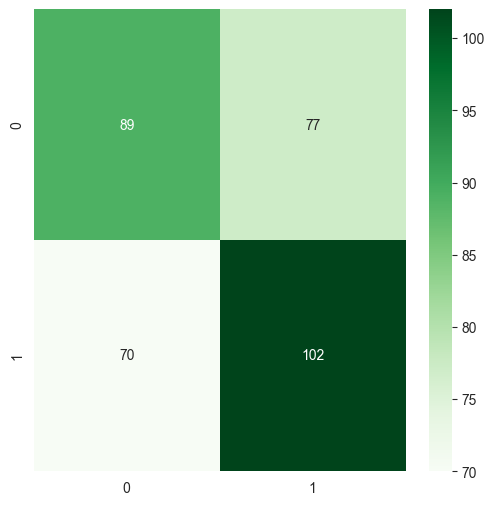

In [31]:
svm8 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
pred_svm8 = svm8.predict(X_test_Fourier_Hist)
confusion_Matrix(confusion_matrix(y_test_Fourier_Hist, pred_svm8))
print(classification_report(y_test_Fourier_Hist, pred_svm8))
print(round(np.sum([y_test_Fourier_Hist == pred_svm8]) / len(y_test_Fourier_Hist), 4) * 100, "%")

results.append(['Fourier and histogram PCA', 'SVM', round(np.sum([y_test_Fourier_Hist == pred_svm8]) / len(y_test_Fourier_Hist), 4) * 100])



#### KNN

In [32]:
n_neighbors_values = range(1, 51)

best_accuracy = 0
best_n_neighbors = 0

for curr_n_neighbors in n_neighbors_values:
    try:
        neigh = KNeighborsClassifier(n_neighbors=curr_n_neighbors)
        neigh.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
        pred_knn = neigh.predict(X_test_Fourier_Hist)
        accuracy = accuracy_score(y_test_Fourier_Hist, pred_knn)
        print(curr_n_neighbors, round(accuracy, 4) * 100, "%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = curr_n_neighbors
    except Exception as e:
        print(f"Error: ${e}")
        

1 65.09 %
2 58.879999999999995 %
3 65.09 %
4 60.36 %
5 66.27 %
6 64.79 %
7 67.46 %
8 68.64 %
9 69.53 %
10 67.75 %
11 68.34 %
12 67.16 %
13 68.05 %
14 66.27 %
15 67.75 %
16 66.27 %
17 68.05 %
18 66.86 %
19 68.05 %
20 66.27 %
21 68.05 %
22 65.38000000000001 %
23 67.16 %
24 66.86 %
25 67.16 %
26 64.2 %
27 65.98 %
28 65.38000000000001 %
29 65.38000000000001 %
30 65.09 %
31 65.98 %
32 65.38000000000001 %
33 65.38000000000001 %
34 63.91 %
35 65.68 %
36 63.61 %
37 65.98 %
38 65.38000000000001 %
39 66.27 %
40 65.98 %
41 67.16 %
42 65.98 %
43 65.98 %
44 65.68 %
45 66.27 %
46 66.57 %
47 66.86 %
48 65.09 %
49 66.27 %
50 65.38000000000001 %


              precision    recall  f1-score   support

           0       0.66      0.77      0.71       166
           1       0.74      0.62      0.68       172

    accuracy                           0.70       338
   macro avg       0.70      0.70      0.69       338
weighted avg       0.70      0.70      0.69       338

69.53 %


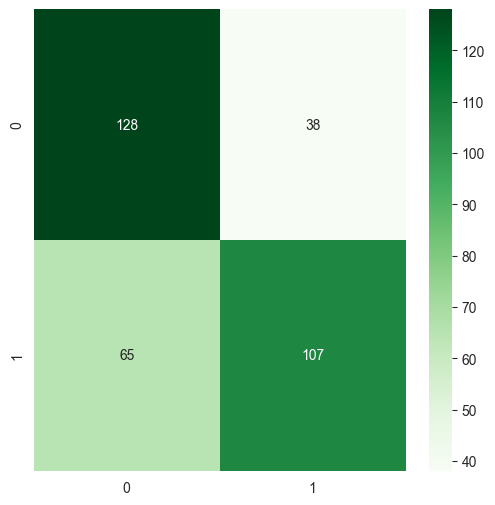

In [33]:
neigh8 = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh8.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
pred_knn8 = neigh8.predict(X_test_Fourier_Hist)
confusion_Matrix(confusion_matrix(y_test_Fourier_Hist, pred_knn8))
print(classification_report(y_test_Fourier_Hist, pred_knn8))
print(round(np.sum([y_test_Fourier_Hist == pred_knn8]) / len(y_test_Fourier_Hist), 4) * 100, "%")
results.append(['Fourier and histogram PCA', 'KNN', round(np.sum([y_test_Fourier_Hist == pred_knn8]) / len(y_test_Fourier_Hist), 4) * 100])



#### Adaboost


In [34]:
best_adaboost_accuracy = 0
best_adaboost_n_estimators = 0

for idx in range(50, 2001, 50):
    try:
        ada = AdaBoostClassifier(n_estimators=idx, algorithm="SAMME", random_state=0)
        ada.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
        pred_ada = ada.predict(X_test_Fourier_Hist)
        accuracy = accuracy_score(y_test_Fourier_Hist, pred_ada)
        print(idx, round(accuracy, 4) * 100, "%")
        if accuracy > best_adaboost_accuracy:
            best_adaboost_accuracy = accuracy
            best_adaboost_n_estimators = idx
    except Exception as e:
        print(f"Error: ${e}")
              

50 67.16 %
100 68.64 %
150 68.34 %
200 68.34 %
250 68.34 %
300 66.57 %
350 67.16 %
400 67.16 %
450 66.86 %
500 67.16 %
550 68.05 %
600 67.75 %
650 66.86 %
700 68.64 %
750 67.16 %
800 67.16 %
850 68.34 %
900 67.75 %
950 68.05 %
1000 67.46 %
1050 67.16 %
1100 67.75 %
1150 68.05 %
1200 68.05 %
1250 67.46 %
1300 68.05 %
1350 68.34 %
1400 69.23 %
1450 68.34 %
1500 68.64 %
1550 68.34 %
1600 68.64 %
1650 68.93 %
1700 68.64 %
1750 68.34 %
1800 68.34 %
1850 68.64 %
1900 68.64 %
1950 69.53 %
2000 69.82000000000001 %


              precision    recall  f1-score   support

           0       0.67      0.77      0.71       166
           1       0.74      0.63      0.68       172

    accuracy                           0.70       338
   macro avg       0.70      0.70      0.70       338
weighted avg       0.70      0.70      0.70       338

69.82000000000001 %


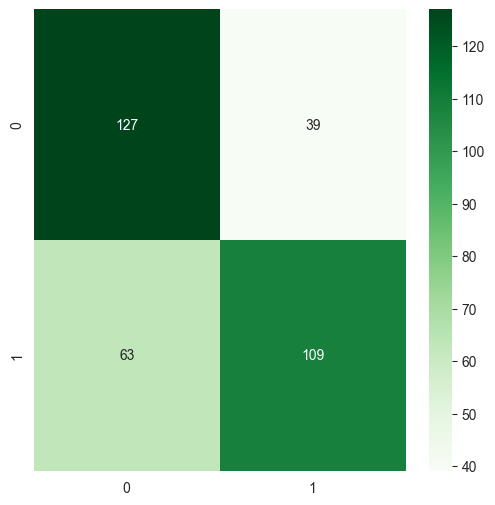

In [35]:
ada8 = AdaBoostClassifier(n_estimators=best_adaboost_n_estimators, algorithm="SAMME", random_state=0)
ada8.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
pred_ada8 = ada8.predict(X_test_Fourier_Hist)
confusion_Matrix(confusion_matrix(y_test_Fourier_Hist, pred_ada8))
print(classification_report(y_test_Fourier_Hist, pred_ada8))
print(round(np.sum([y_test_Fourier_Hist == pred_ada8]) / len(y_test_Fourier_Hist), 4) * 100, "%")
results.append(['Fourier and histogram PCA', 'Adaboost', round(np.sum([y_test_Fourier_Hist == pred_ada8]) / len(y_test_Fourier_Hist), 4) * 100])


#### Random Forest

In [36]:
best_rand_forest_accuracy = 0
best_n_estimators = 0

for curr_estimator in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=curr_estimator, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
        pred_RF = RF.predict(X_test_Fourier_Hist)
        accuracy = accuracy_score(y_test_Fourier_Hist, pred_RF)
        print(curr_estimator, j, round(accuracy, 4) * 100, "%")
        if accuracy > best_rand_forest_accuracy:
            best_rand_forest_accuracy = accuracy
            best_n_estimators = curr_estimator
            

40 2 75.74 %
40 3 72.78 %
40 4 73.67 %
60 2 74.85000000000001 %
60 3 74.56 %
60 4 73.67 %
80 2 74.56 %
80 3 74.56 %
80 4 74.56 %
100 2 74.26 %
100 3 72.78 %
100 4 74.85000000000001 %
120 2 73.08 %
120 3 74.26 %
120 4 75.74 %
140 2 74.26 %
140 3 75.14999999999999 %
140 4 74.85000000000001 %
160 2 74.85000000000001 %
160 3 76.03999999999999 %
160 4 75.14999999999999 %
180 2 75.14999999999999 %
180 3 75.74 %
180 4 76.63 %
200 2 74.85000000000001 %
200 3 75.44 %
200 4 76.92 %
220 2 74.85000000000001 %
220 3 75.44 %
220 4 77.81 %
240 2 75.44 %
240 3 75.44 %
240 4 77.22 %
260 2 75.74 %
260 3 76.03999999999999 %
260 4 77.81 %
280 2 75.44 %
280 3 75.74 %
280 4 77.51 %
300 2 75.44 %
300 3 75.14999999999999 %
300 4 76.92 %
320 2 74.85000000000001 %
320 3 75.14999999999999 %
320 4 76.92 %
340 2 75.44 %
340 3 74.85000000000001 %
340 4 76.63 %
360 2 75.74 %
360 3 75.44 %
360 4 76.63 %
380 2 75.14999999999999 %
380 3 75.14999999999999 %
380 4 76.33 %
400 2 74.56 %
400 3 74.85000000000001 %
400 4 76.

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       166
           1       0.78      0.72      0.75       172

    accuracy                           0.75       338
   macro avg       0.76      0.76      0.75       338
weighted avg       0.76      0.75      0.75       338

75.44 %


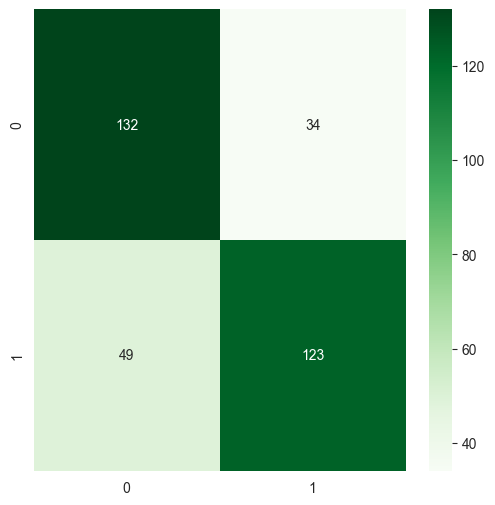

In [37]:
RF8 = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=3, random_state=0)
RF8.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
pred_RF8 = RF8.predict(X_test_Fourier_Hist)
confusion_Matrix(confusion_matrix(y_test_Fourier_Hist, pred_RF8))
print(classification_report(y_test_Fourier_Hist, pred_RF8))
print(round(np.sum([y_test_Fourier_Hist == pred_RF8]) / len(y_test_Fourier_Hist), 4) * 100, "%")
results.append(['Fourier and histogram PCA', 'Random Forest', round(np.sum([y_test_Fourier_Hist == pred_RF8]) / len(y_test_Fourier_Hist), 4) * 100])
          
        

#### Logistic Regression

In [38]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
                pred_LR = LR.predict(X_test_Fourier_Hist)
                accuracy = accuracy_score(y_test_Fourier_Hist, pred_LR)
                print(p, s, t, round(accuracy, 4) * 100, "%")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params["penalty"] = p
                    best_params["solver"] = s
                    best_params["tol"] = t
            except Exception as e:
                print(f"Error: ${e}")

Error: $Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
l1 liblinear 0.1 66.57 %
l1 liblinear 0.01 66.86 %
l1 liblinear 0.001 67.46 %
Error: $Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver sag supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver sag supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver sag supports only 'l2' or None penalties, go

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       166
           1       0.71      0.65      0.68       172

    accuracy                           0.69       338
   macro avg       0.69      0.69      0.69       338
weighted avg       0.69      0.69      0.69       338

68.64 %


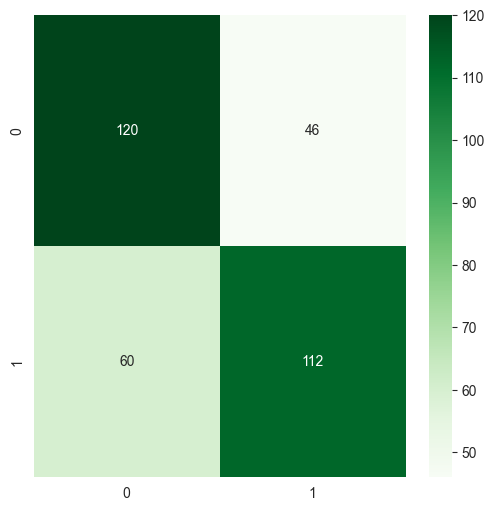

In [39]:
LR8 = LogisticRegression(penalty=best_params["penalty"], solver=best_params["solver"], tol=best_params["tol"], max_iter=10000, random_state=0)
LR8.fit(X_train_Fourier_Hist, y_train_Fourier_Hist)
pred_LR8 = LR8.predict(X_test_Fourier_Hist)
confusion_Matrix(confusion_matrix(y_test_Fourier_Hist, pred_LR8))
print(classification_report(y_test_Fourier_Hist, pred_LR8))
print(round(np.sum([y_test_Fourier_Hist == pred_LR8]) / len(y_test_Fourier_Hist), 4) * 100, "%")

results.append(['Fourier and histogram PCA', 'Logistic Regression', round(np.sum([y_test_Fourier_Hist == pred_LR8]) / len(y_test_Fourier_Hist), 4) * 100])



## Run on all features using PCA


In [40]:
#creating new df using PCA

cols = [i for i in range(128)]
df_all = pd.DataFrame(X_train_all, columns=cols)
cy = []
for i in y_train_all:
    cy.append(i)
df_all['class_number'] = cy
df_all.to_csv('df_all.csv', index=False)


#### SVM    


In [41]:
best_score = 0
best_params = {"loss": None, "penalty": None}

losses = ["hinge", "squared_hinge"]
penalties = ["l1", "l2"]

print("OneVsOneClassifier")
for my_loss in losses:
    for my_penalty in penalties:
        try:
            svm = OneVsOneClassifier(LinearSVC(random_state=0, loss=my_loss, penalty=my_penalty, )).fit(X_train_all,
                                                                                                        y_train_all)
            pred_svm = svm.predict(X_test_all)
            accuracy = accuracy_score(y_test_all, pred_svm)
            print(my_loss, my_penalty, round(accuracy, 4) * 100, "%")
            if accuracy > best_score:
                best_score = accuracy
                best_params["loss"] = my_loss
                best_params["penalty"] = my_penalty
        except Exception as e:
            print(f"error: ${e}")
            

OneVsOneClassifier
error: $Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
hinge l2 66.86 %
error: $Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
squared_hinge l2 66.86 %


              precision    recall  f1-score   support

           0       0.67      0.65      0.66       166
           1       0.67      0.69      0.68       172

    accuracy                           0.67       338
   macro avg       0.67      0.67      0.67       338
weighted avg       0.67      0.67      0.67       338

66.86 %


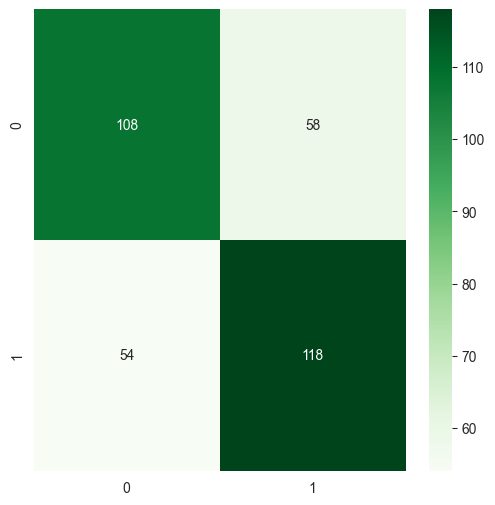

In [42]:
svm8 = OneVsOneClassifier(LinearSVC(random_state=0, loss=best_params["loss"], penalty=best_params["penalty"])).fit(
    X_train_all, y_train_all)
pred_svm8 = svm8.predict(X_test_all)
confusion_Matrix(confusion_matrix(y_test_all, pred_svm8))
print(classification_report(y_test_all, pred_svm8))
print(round(np.sum([y_test_all == pred_svm8]) / len(y_test_all), 4) * 100, "%")
results.append(['All features PCA', 'SVM', round(np.sum([y_test_all == pred_svm8]) / len(y_test_all), 4) * 100])


#### KNN


In [43]:
n_neighbors_values= range(1, 51)

best_accuracy = 0
best_n_neighbors = 0

for curr_n_neighbors in n_neighbors_values:
    try:
        neigh = KNeighborsClassifier(n_neighbors=curr_n_neighbors)
        neigh.fit(X_train_all, y_train_all)
        pred_knn = neigh.predict(X_test_all)
        accuracy = accuracy_score(y_test_all, pred_knn)
        print(curr_n_neighbors, round(accuracy, 4) * 100, "%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = curr_n_neighbors
    except Exception as e:
        print(f"Error: ${e}")
        

1 78.99000000000001 %
2 70.41 %
3 76.03999999999999 %
4 73.67 %
5 77.51 %
6 74.85000000000001 %
7 76.92 %
8 75.74 %
9 76.63 %
10 73.96000000000001 %
11 75.74 %
12 72.78 %
13 73.67 %
14 74.56 %
15 74.26 %
16 71.89 %
17 73.37 %
18 71.00999999999999 %
19 72.49 %
20 70.71 %
21 71.89 %
22 69.82000000000001 %
23 72.78 %
24 70.71 %
25 73.08 %
26 71.00999999999999 %
27 72.78 %
28 71.00999999999999 %
29 72.19 %
30 71.00999999999999 %
31 71.89 %
32 71.6 %
33 70.71 %
34 68.64 %
35 70.12 %
36 69.23 %
37 70.12 %
38 69.23 %
39 68.93 %
40 68.64 %
41 69.82000000000001 %
42 68.34 %
43 68.93 %
44 68.64 %
45 68.93 %
46 69.53 %
47 70.12 %
48 69.53 %
49 69.53 %
50 68.93 %


              precision    recall  f1-score   support

           0       0.78      0.80      0.79       166
           1       0.80      0.78      0.79       172

    accuracy                           0.79       338
   macro avg       0.79      0.79      0.79       338
weighted avg       0.79      0.79      0.79       338

78.99000000000001 %


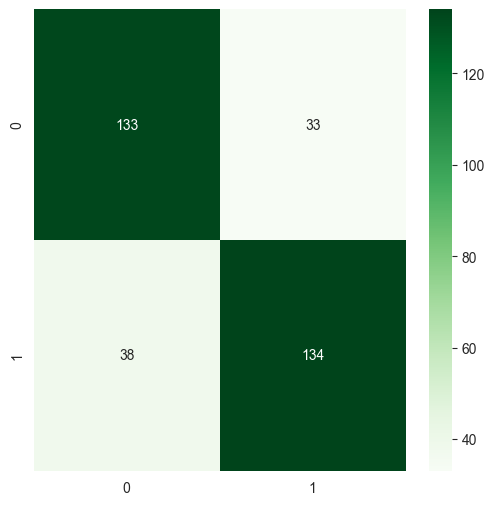

In [44]:
neigh8 = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh8.fit(X_train_all, y_train_all)
pred_knn8 = neigh8.predict(X_test_all)
confusion_Matrix(confusion_matrix(y_test_all, pred_knn8))
print(classification_report(y_test_all, pred_knn8))
print(round(np.sum([y_test_all == pred_knn8]) / len(y_test_all), 4) * 100, "%")
results.append(['All features PCA', 'KNN', round(np.sum([y_test_all == pred_knn8]) / len(y_test_all), 4) * 100])


#### Adaboost


In [45]:
best_adaboost_accuracy = 0
best_adaboost_n_estimators = 0
for idx in range(50, 2001, 50):
    try:
        ada = AdaBoostClassifier(n_estimators=idx, algorithm="SAMME", random_state=0)
        ada.fit(X_train_all, y_train_all)
        pred_ada = ada.predict(X_test_all)
        accuracy = accuracy_score(y_test_all, pred_ada)
        print(idx, round(accuracy, 4) * 100, "%")
        if accuracy > best_adaboost_accuracy:
            best_adaboost_accuracy = accuracy
            best_adaboost_n_estimators = idx
    except Exception as e:
        print(f"Error: ${e}")
        

50 71.6 %
100 72.49 %
150 73.37 %
200 71.89 %
250 72.19 %
300 72.19 %
350 73.96000000000001 %
400 74.26 %
450 72.49 %
500 73.96000000000001 %
550 75.44 %
600 73.96000000000001 %
650 73.08 %
700 74.56 %
750 75.14999999999999 %
800 74.85000000000001 %
850 74.56 %
900 75.14999999999999 %
950 74.26 %
1000 73.37 %
1050 72.78 %
1100 74.56 %
1150 72.49 %
1200 71.89 %
1250 72.19 %
1300 72.78 %
1350 72.49 %
1400 73.96000000000001 %
1450 73.37 %
1500 73.08 %
1550 71.89 %
1600 72.19 %
1650 72.19 %
1700 71.6 %
1750 71.89 %
1800 71.89 %
1850 72.78 %
1900 73.37 %
1950 71.3 %
2000 71.89 %


              precision    recall  f1-score   support

           0       0.74      0.78      0.76       166
           1       0.77      0.73      0.75       172

    accuracy                           0.75       338
   macro avg       0.76      0.75      0.75       338
weighted avg       0.76      0.75      0.75       338

75.44 %


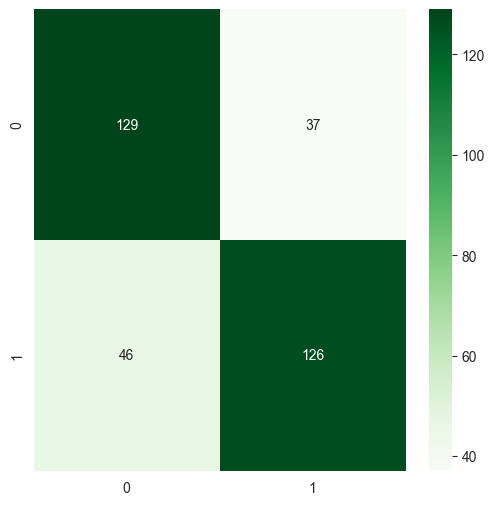

In [46]:
ada8 = AdaBoostClassifier(n_estimators=best_adaboost_n_estimators, algorithm="SAMME", random_state=0)
ada8.fit(X_train_all, y_train_all)
pred_ada8 = ada8.predict(X_test_all)
confusion_Matrix(confusion_matrix(y_test_all, pred_ada8))
print(classification_report(y_test_all, pred_ada8))
print(round(np.sum([y_test_all == pred_ada8]) / len(y_test_all), 4) * 100, "%")
results.append(['All features PCA', 'Adaboost', round(np.sum([y_test_all == pred_ada8]) / len(y_test_all), 4) * 100])


#### Random Forest


In [47]:
best_rand_forest_accuracy = 0
best_n_estimators = 0

for curr_estimator in range(40, 501, 20):
    for j in range(2, 5):
        RF = RandomForestClassifier(n_estimators=curr_estimator, max_depth=None, min_samples_split=j, random_state=0)
        RF.fit(X_train_all, y_train_all)
        pred_RF = RF.predict(X_test_all)
        accuracy = accuracy_score(y_test_all, pred_RF)
        print(curr_estimator, j, round(accuracy, 4) * 100, "%")
        if accuracy > best_rand_forest_accuracy:
            best_rand_forest_accuracy = accuracy
            best_n_estimators = curr_estimator
            

40 2 78.4 %
40 3 80.47 %
40 4 80.17999999999999 %
60 2 81.07 %
60 3 81.36 %
60 4 79.88 %
80 2 80.17999999999999 %
80 3 81.07 %
80 4 80.47 %
100 2 81.66 %
100 3 83.14 %
100 4 79.88 %
120 2 81.66 %
120 3 83.43 %
120 4 81.07 %
140 2 81.95 %
140 3 83.14 %
140 4 81.36 %
160 2 82.25 %
160 3 83.73 %
160 4 81.07 %
180 2 81.66 %
180 3 83.73 %
180 4 80.47 %
200 2 81.95 %
200 3 82.84 %
200 4 80.47 %
220 2 83.14 %
220 3 83.14 %
220 4 80.77 %
240 2 83.14 %
240 3 82.84 %
240 4 81.36 %
260 2 83.73 %
260 3 83.73 %
260 4 80.77 %
280 2 82.84 %
280 3 84.02 %
280 4 81.07 %
300 2 82.54 %
300 3 82.25 %
300 4 81.36 %
320 2 82.25 %
320 3 82.84 %
320 4 80.77 %
340 2 83.73 %
340 3 84.02 %
340 4 81.07 %
360 2 84.02 %
360 3 83.73 %
360 4 80.47 %
380 2 83.73 %
380 3 83.43 %
380 4 81.07 %
400 2 82.84 %
400 3 83.43 %
400 4 81.07 %
420 2 82.54 %
420 3 83.73 %
420 4 81.07 %
440 2 82.84 %
440 3 83.73 %
440 4 81.66 %
460 2 82.54 %
460 3 83.43 %
460 4 81.95 %
480 2 82.54 %
480 3 84.02 %
480 4 82.54 %
500 2 82.25 %
500 3 

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       166
           1       0.86      0.81      0.84       172

    accuracy                           0.84       338
   macro avg       0.84      0.84      0.84       338
weighted avg       0.84      0.84      0.84       338

84.02 %


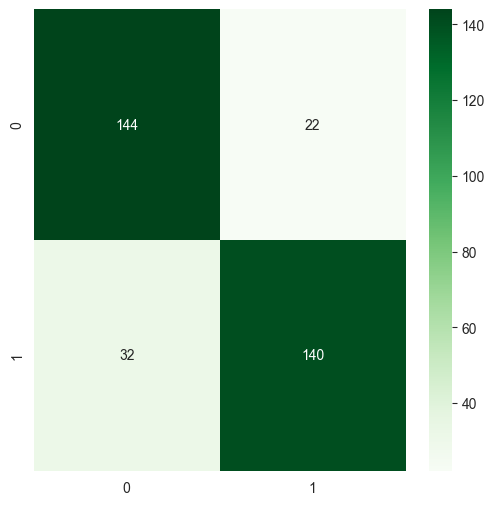

In [48]:
RF8 = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=3, random_state=0)
RF8.fit(X_train_all, y_train_all)
pred_RF8 = RF8.predict(X_test_all)
confusion_Matrix(confusion_matrix(y_test_all, pred_RF8))
print(classification_report(y_test_all, pred_RF8))
print(round(np.sum([y_test_all == pred_RF8]) / len(y_test_all), 4) * 100, "%")
results.append(['All features PCA', 'Random Forest', round(np.sum([y_test_all == pred_RF8]) / len(y_test_all), 4) * 100])


#### Logistic Regression


In [49]:
best_accuracy = 0
best_params = {"penalty": None, "solver": None, "tol": None}

penalties = ["l1", "l2", "elasticnet"]
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
tols = [0.1, 0.01, 0.001]

for p in penalties:
    for s in solvers:
        for t in tols:
            try:
                LR = LogisticRegression(penalty=p, solver=s, tol=t, max_iter=10000, random_state=0)
                LR.fit(X_train_all, y_train_all)
                pred_LR = LR.predict(X_test_all)
                accuracy = accuracy_score(y_test_all, pred_LR)
                print(p, s, t, round(accuracy, 4) * 100, "%")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params["penalty"] = p
                    best_params["solver"] = s
                    best_params["tol"] = t
            except Exception as e:
                print(f"Error: ${e}")
                

Error: $Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
l1 liblinear 0.1 76.92 %
l1 liblinear 0.01 75.44 %
l1 liblinear 0.001 75.74 %
Error: $Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver sag supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver sag supports only 'l2' or None penalties, got l1 penalty.
Error: $Solver sag supports only 'l2' or None penalties, go

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       166
           1       0.78      0.76      0.77       172

    accuracy                           0.77       338
   macro avg       0.77      0.77      0.77       338
weighted avg       0.77      0.77      0.77       338

77.22 %


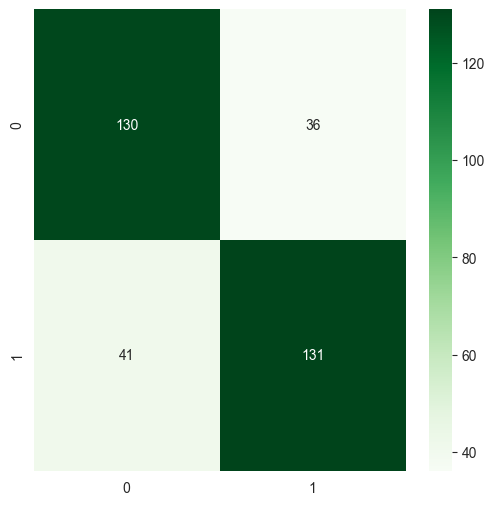

In [50]:
LR8 = LogisticRegression(penalty=best_params["penalty"], solver=best_params["solver"], tol=best_params["tol"], max_iter=10000, random_state=0)
LR8.fit(X_train_all, y_train_all)
pred_LR8 = LR8.predict(X_test_all)
confusion_Matrix(confusion_matrix(y_test_all, pred_LR8))
print(classification_report(y_test_all, pred_LR8))
print(round(np.sum([y_test_all == pred_LR8]) / len(y_test_all), 4) * 100, "%")
results.append(['All features PCA', 'Logistic Regression', round(np.sum([y_test_all == pred_LR8]) / len(y_test_all), 4) * 100])


# The End